location is unique : True
the target lives at 46.54987279652849, 6.582757515785049
location is unique : True
the target works at 46.540782352683166, 6.5918965877586055
the target likes the most going at the club located at 46.55441734505941, 6.5864349944406655


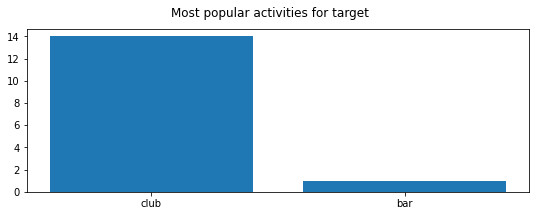

the target likes the most eating in supermarket located at 46.554051392505166, 6.583896376853933


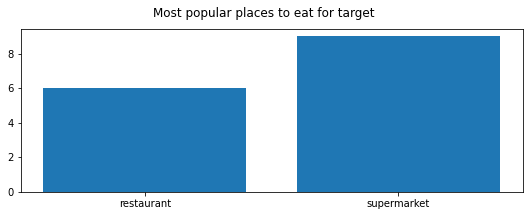

location is unique : False
Here, we should have multiple possible locations (since the cell spans on a bigger area), thus making the seeking of the exact location way harder.
the target likes the most going at the club located at 46.55441734505941, 6.5864349944406655


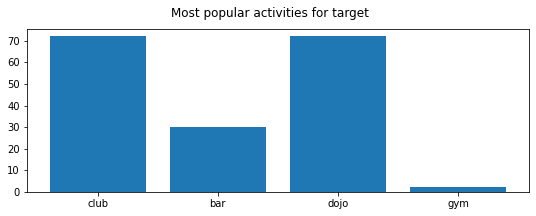

In [15]:
import csv
import matplotlib.pyplot as plt
from grid import location_to_cell_id
#===================================== PRIVACY EVALUATION ========================================================

pois = {}
# Store all POIs by type  
with open("pois.csv", newline="") as pois_csv:
    reader = csv.reader(pois_csv, delimiter=" ")
    next(reader)
    for poi_row in reader:
        poi_id, cell_id, poi_type, lat, lon = poi_row
        poi_id, cell_id = int(poi_id), int(cell_id)
        lat, lon = float(lat), float(lon)
        if poi_type not in pois.keys():
            pois[poi_type] = [(poi_id, cell_id, lat, lon)]
        else:
            pois[poi_type].append((poi_id, cell_id, lat, lon))
         
            
queries = {}
# Store all queries by requester (ip_address)
with open("queries.csv", newline="") as queries_csv:
    reader = csv.reader(queries_csv, delimiter=" ")
    next(reader)
    for query_row in reader:
        ip_address, lat, lon, timestamp, poi_query_type = query_row
        lat, lon, timestamp = float(lat), float(lon), float(timestamp)
        if ip_address not in queries.keys():
            queries[ip_address] = [(lat, lon, timestamp, poi_query_type)]
        else:
            queries[ip_address].append((lat, lon, timestamp, poi_query_type))


# For each user (IP addresses), we associate a list for the given types of POIs with the locations
def find_poi_location_from_types(types):
    locs = {}
    # Copy list of pois
    for poi_type in types:
        # store the corresponding pois for a given type
        locs[poi_type] = pois[poi_type]

    ip_to_loc = {}
    # Associate each ip to the pois corresponding to his queries
    for ip in list(queries.keys()):
        ip_to_loc[ip] = []
        for query_lat, query_lon, _, _ in queries[ip]:
            for loc_poi_type in locs:
                loc = locs[loc_poi_type]
                for poi_id, cell_id, loc_lat, loc_lon in loc:
                    if loc_lat == query_lat and loc_lon == query_lon:
                        ip_to_loc[ip].append((loc_poi_type, poi_id, cell_id, loc_lat, loc_lon))
    return ip_to_loc

#define types of POIs
type_work = ["office", "company", "laboratory"]
type_home = ["villa", "appartment_block"]
type_activity = ["club", "gym", "bar", "dojo"]
type_place_to_eat = ["restaurant", "cafeteria", "supermarket"]

home_pois = find_poi_location_from_types(type_home)
work_pois = find_poi_location_from_types(type_work)
activity_pois = find_poi_location_from_types(type_activity)     
place_to_eat_pois = find_poi_location_from_types(type_place_to_eat) 
 
# This method can be used to make sure that we obtain always the same location, hence validating that it is the right location
def is_unique(locations): 
    prev_loc = locations[0]
    for loc in locations:
        if prev_loc != loc:
            return False
        prev_loc = loc
    return True


# Given a known IP, let's deduce some informations
target_ip = "37.93.75.56"
target_queries = queries[target_ip]

print("location is unique : " + str(is_unique(home_pois[target_ip])))
target_home_loc = list(home_pois[target_ip])[0]
print("the target lives at " + str(target_home_loc[3]) + ", " + str(target_home_loc[4]))

print("location is unique : " + str(is_unique(work_pois[target_ip])))
target_work_loc = list(work_pois[target_ip])[0]
print("the target works at " + str(target_work_loc[3]) + ", " + str(target_work_loc[4]))

# We can also check the places of activities the user goes to the most, by comparing the count of total queries
poi_activity_count = {}
for k, v in activity_pois.items():
        poi_activity_count[k] = {poi: v.count(poi) for poi in v}
activities = poi_activity_count[target_ip]

if len(list(activities.values())) != 0:
    # By finding the max count, we can find the activity the target likes the most, as well as the location
    max_val = max(list(activities.values()))
    act = [act for act, val in activities.items() if val == max_val][0]
    print("the target likes the most going at the " + str(act[0]) + " located at " + str(act[3]) + ", " + str(act[4]))
    
    values = list(activities.values())
    poi_types = list()
    for poi in list(activities.keys()):
        poi_types.append(poi[0])
    names = poi_types    

    plt.figure(figsize=(9, 3))
    plt.bar(names, values)
    plt.suptitle('Most popular activities for target')
    plt.show()
    
else:
    print("no info")     
    
    
# Same for the places to eat
poi_eat_places_count = {}
for k, v in place_to_eat_pois.items():
        poi_eat_places_count[k] = {poi: v.count(poi) for poi in v}
place_to_eat = poi_eat_places_count[target_ip]

if len(list(place_to_eat.values())) != 0:     
    max_val = max(list(place_to_eat.values()))
    place = [place for place, val in place_to_eat.items() if val == max_val][0]
    print("the target likes the most eating in " + str(place[0]) + " located at " + str(place[3]) + ", " + str(place[4]))
    
    values = list(place_to_eat.values())
    poi_types = list()
    for poi in list(place_to_eat.keys()):
        poi_types.append(poi[0])
    names = poi_types    

    plt.figure(figsize=(9, 3))
    plt.bar(names, values)
    plt.suptitle('Most popular places to eat for target')
    plt.show()
else:
    print("no info")
    
#===================================== DEFENSE =============================================================

# Instead of using locations for the queries, we convert to cells

queries = {}
# Store all queries by requester (ip_address)
with open("queries.csv", newline="") as queries_csv:
    reader = csv.reader(queries_csv, delimiter=" ")
    next(reader)
    for query_row in reader:
        ip_address, lat, lon, timestamp, poi_query_type = query_row
        lat, lon, timestamp = float(lat), float(lon), float(timestamp)
        if ip_address not in queries.keys():
            queries[ip_address] = [(location_to_cell_id(lat, lon), timestamp, poi_query_type)]
        else:
            queries[ip_address].append((location_to_cell_id(lat, lon), timestamp, poi_query_type))    
            
# Now, if we try the attacks, it's harder to get the exact location
def find_poi_location_from_types(types):
    locs = {}
    # Copy list of pois
    for poi_type in types:
        # store the corresponding pois for a given type
        locs[poi_type] = pois[poi_type]

    ip_to_loc = {}
    # Associate each ip to the pois corresponding to his queries
    for ip in list(queries.keys()):
        ip_to_loc[ip] = []
        for query_cell_id, _, _ in queries[ip]:
            for loc_poi_type in locs:
                loc = locs[loc_poi_type]
                for poi_id, cell_id, loc_lat, loc_lon in loc:
                    if query_cell_id == cell_id:
                        ip_to_loc[ip].append((loc_poi_type, poi_id, cell_id, loc_lat, loc_lon))
    return ip_to_loc

#define types of POIs
type_work = ["office", "company", "laboratory"]
type_home = ["villa", "appartment_block"]
type_activity = ["club", "gym", "bar", "dojo"]
type_place_to_eat = ["restaurant", "cafeteria", "supermarket"]

home_pois = find_poi_location_from_types(type_home)
work_pois = find_poi_location_from_types(type_work)
activity_pois = find_poi_location_from_types(type_activity)     
place_to_eat_pois = find_poi_location_from_types(type_place_to_eat) 
            
# Given a known IP, let's deduce some informations
target_ip = "37.93.75.56"
target_queries = queries[target_ip]
target_home_loc = list(home_pois[target_ip])[0]
print("location is unique : " + str(is_unique(home_pois[target_ip])))
print("Here, we should have multiple possible locations (since the cell spans on a bigger area), thus making the seeking of the exact location way harder.")

# Let's now try to determine the activities
poi_activity_count = {}
for k, v in activity_pois.items():
        poi_activity_count[k] = {poi: v.count(poi) for poi in v}
activities = poi_activity_count[target_ip]

if len(list(activities.values())) != 0:
    # By finding the max count, we can find the activity the target likes the most, as well as the location
    max_val = max(list(activities.values()))
    act = [act for act, val in activities.items() if val == max_val][0]
    print("the target likes the most going at the " + str(act[0]) + " located at " + str(act[3]) + ", " + str(act[4]))
    
    values = list(activities.values())
    poi_types = list()
    for poi in list(activities.keys()):
        poi_types.append(poi[0])
    names = poi_types    

    plt.figure(figsize=(9, 3))
    plt.bar(names, values)
    plt.suptitle('Most popular activities for target')
    plt.show()
    
else:
    print("no info")     